In [ ]:
!pip install torch torchvision
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install faiss-gpu

In [ ]:
from google.colab import drive
import torch
import faiss
import numpy as np
from PIL import Image
from transformers import AlignProcessor, AlignModel
from torch.utils.data import DataLoader

# Step 1: Mount Google Drive
drive.mount('/content/drive')

In [ ]:
train_path = '/content/drive/My Drive/Building_images_train/'
train_label_path = '/content/drive/My Drive/Building_images_train/train_labels.json'
output_dir = '/content/drive/My Drive/Image_text models/ALIGN_fine-tunned'

In [ ]:
def get_align():
    processor = AlignProcessor.from_pretrained("kakaobrain/align-base")
    model = AlignModel.from_pretrained("kakaobrain/align-base")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    return model, processor, device

In [ ]:
import os
import torch
import json
import numpy as np
from PIL import Image
from transformers import AlignProcessor, AlignModel, AdamW
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor

# Dataset class for images and labels
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_file, processor, transform=None):
        self.image_dir = image_dir
        self.processor = processor
        self.transform = transform
        with open(label_file, 'r') as f:
            self.labels = json.load(f)
        self.image_paths = list(self.labels.keys())

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        labels = self.labels[self.image_paths[idx]]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, labels

# Custom collate function for processing text labels
def collate_fn(batch):
    images, label_lists = zip(*batch)
    all_labels = [label for sublist in label_lists for label in sublist]
    return images, all_labels

# Fine-tune the ALIGN model
def fine_tune_align(image_dir, label_file, output_dir, epochs=20, batch_size=8, lr=1e-5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AlignProcessor.from_pretrained("kakaobrain/align-base")
    model = AlignModel.from_pretrained("kakaobrain/align-base")
    model.to(device)

    # Image transformations
    transform = Compose([Resize((224, 224)), ToTensor()])

    # Create dataset and dataloader
    dataset = ImageDataset(image_dir, label_file, processor, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

    # Optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for images, all_labels in dataloader:
            # Process images
            inputs = processor(images=images, return_tensors="pt").to(device)
            image_features = model.get_image_features(**inputs)

            # Process text labels
            text_inputs = processor(text=all_labels, return_tensors="pt", padding=True, truncation=True).to(device)
            text_features = model.get_text_features(**text_inputs)

            # Compute similarity
            logits = torch.matmul(image_features, text_features.T)
            targets = torch.arange(len(images)).to(device)

            # Compute loss
            loss = loss_fn(logits, targets)
            epoch_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss / len(dataloader)}")

In [ ]:
# Save the fine-tuned model
model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)
print(f"Fine-tuned model saved to {output_dir}")

Fine-tuned model saved to /content/drive/My Drive/Image_text models/ALIGN_fine-tunned


In [ ]:
import matplotlib.pyplot as plt
def visualize_results(results):
    """
    Display retrieved images with their corresponding similarity scores.
    Args:
        results (list of tuples): List containing tuples of (image_path, score).
    """
    if not results:
        print("No results to display.")
        return

    plt.figure(figsize=(15, 5))

    for i, (image_path, score) in enumerate(results):
        # Load and display image
        img = Image.open(image_path).convert("RGB")
        plt.subplot(1, len(results), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Score: {score:.2f}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Inference function after fine-tuning
def infer_align(query, image_dir, model_dir, top_k=5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AlignProcessor.from_pretrained(model_dir)
    model = AlignModel.from_pretrained(model_dir)
    model.to(device)

    # Encode all images
    image_embeddings, image_paths = preprocess_align(image_dir, processor, model, device)
    index = embed_align(image_embeddings)

    # Perform search
    results = search_align(query, index, model, processor, image_paths, device, top_k=top_k)

    # Visualize the results

    return results


Epoch 1/20 Loss: 20503.796919389206
Epoch 2/20 Loss: 10392.332341974432
Epoch 3/20 Loss: 5451.923850319602


KeyboardInterrupt: 

In [ ]:
# Paths to your data
image_dir = train_path
label_file = train_label_path

In [ ]:
# Fine-tuning
fine_tune_align(image_dir, label_file, output_dir)

In [ ]:
# Inference after fine-tuning
query = "bedroom"
results = infer_align(query, image_dir, output_dir)
print("Results:", results)

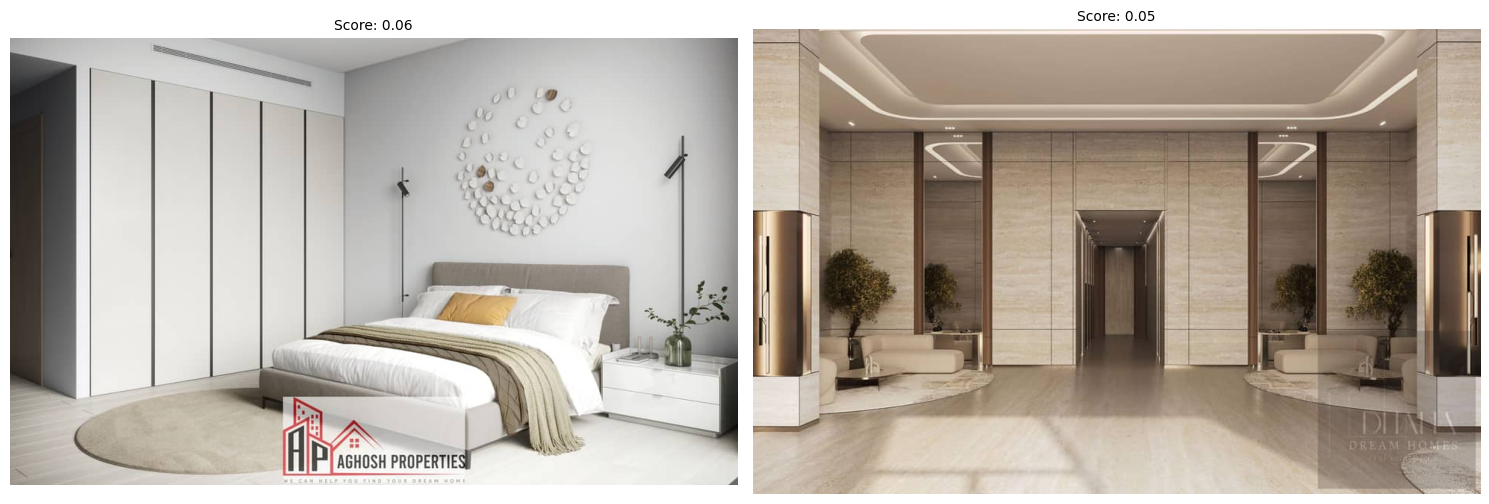

In [ ]:
visualize_results(results)

In [ ]:
import os
import torch
import json
import numpy as np
from PIL import Image
from transformers import AlignProcessor, AlignModel, AdamW
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor
import matplotlib.pyplot as plt
import faiss

# Dataset class for images and labels
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_file, processor, transform=None):
        self.image_dir = image_dir
        self.processor = processor
        self.transform = transform
        with open(label_file, 'r') as f:
            self.labels = json.load(f)
        self.image_paths = list(self.labels.keys())

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        labels = self.labels[self.image_paths[idx]]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, labels

# Custom collate function for processing text labels
def collate_fn(batch):
    """
    Custom collate function to handle image-label pairs.
    Args:
        batch: List of tuples (image, labels).
    Returns:
        images: List of images in the batch.
        all_labels: List of lists where each sublist contains labels for an image.
    """
    images, all_labels = zip(*batch)
    return list(images), list(all_labels)


# Preprocess and encode images
def preprocess_align(image_dir, processor, model, device):
    image_embeddings = []
    image_paths = []

    for filename in os.listdir(image_dir):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path).convert("RGB")
            inputs = processor(images=image, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model.get_image_features(**inputs)
            embedding = torch.nn.functional.normalize(outputs, p=2, dim=1).cpu().numpy()
            image_embeddings.append(embedding)
            image_paths.append(image_path)

    image_embeddings = np.vstack(image_embeddings).astype(np.float32)
    faiss.normalize_L2(image_embeddings)  # Ensure embeddings are normalized
    return image_embeddings, image_paths

# Embed ALIGN for FAISS search
def embed_align(image_embeddings):
    index = faiss.IndexFlatIP(image_embeddings.shape[1])  # Cosine similarity
    index.add(image_embeddings)
    return index

# Search and retrieve images
def search_align(query, index, model, processor, image_paths, device, top_k=5):
    inputs = processor(text=[query], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_text_features(**inputs)
    text_embedding = torch.nn.functional.normalize(outputs, p=2, dim=1).cpu().numpy()
    faiss.normalize_L2(text_embedding)  # Normalize query embedding
    D, I = index.search(text_embedding, top_k)

    results = [(image_paths[i], D[0][idx]) for idx, i in enumerate(I[0])]
    return results


def fine_tune_align(image_dir, label_file, output_dir, epochs=100, batch_size=16, lr=1e-5, margin=1.0):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AlignProcessor.from_pretrained("kakaobrain/align-base")
    model = AlignModel.from_pretrained("kakaobrain/align-base")
    model.to(device)

    # Image transformations
    transform = Compose([Resize((224, 224)), ToTensor(), lambda x: x / 255.0])  # Normalize pixel values

    # Create dataset and dataloader
    dataset = ImageDataset(image_dir, label_file, processor, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=lr)

    # Contrastive loss function
    def contrastive_loss(image_features, text_features, margin):
        cosine_sim = torch.nn.functional.cosine_similarity(image_features, text_features)
        positive_loss = (1 - cosine_sim) ** 2  # For positive pairs
        negative_loss = torch.clamp(cosine_sim - margin, min=0) ** 2  # For negative pairs
        return positive_loss.mean() + negative_loss.mean()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for images, all_labels in dataloader:
            # Process images
            inputs = processor(images=images, return_tensors="pt").to(device)
            image_features = model.get_image_features(**inputs)
            image_features = torch.nn.functional.normalize(image_features, p=2, dim=1)

            # Process text labels
            text_features = []
            for labels in all_labels:
                if len(labels) > 0:
                    text_inputs = processor(text=labels, return_tensors="pt", padding=True, truncation=True).to(device)
                    label_features = model.get_text_features(**text_inputs)
                    label_features = torch.nn.functional.normalize(label_features, p=2, dim=1)
                    text_features.append(label_features.mean(dim=0))  # Average embeddings for multiple labels
                else:
                    # Handle empty labels case
                    print("Warning: Missing labels for an image.")
                    text_features.append(torch.zeros(image_features.size(1)).to(device))  # Add dummy embedding

            # Stack text embeddings to match image batch size
            text_features = torch.stack(text_features).to(device)

            # Ensure alignment
            assert text_features.size(0) == image_features.size(0), "Image and text features batch sizes do not match!"

            # Compute contrastive loss
            loss = contrastive_loss(image_features, text_features, margin)
            epoch_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss / len(dataloader)}")

    # Save the fine-tuned model
    return model, processor



In [ ]:
# Paths to your data
image_dir = train_path
label_file = train_label_path

In [ ]:
# Fine-tuning
model, processor = fine_tune_align(image_dir, label_file, output_dir)

Epoch 1/100 Loss: 0.6229943002289441
Epoch 2/100 Loss: 0.36243704413039696
Epoch 3/100 Loss: 0.2797105122415513
Epoch 4/100 Loss: 0.23535549825954932
Epoch 5/100 Loss: 0.20654975684658852
Epoch 6/100 Loss: 0.18548576611002493
Epoch 7/100 Loss: 0.16491621582156019
Epoch 8/100 Loss: 0.14931246352628105
Epoch 9/100 Loss: 0.13424314431112666
Epoch 10/100 Loss: 0.12631117456008734
Epoch 11/100 Loss: 0.11584354593500572
Epoch 12/100 Loss: 0.10678391673944775
Epoch 13/100 Loss: 0.09808830978648032
Epoch 14/100 Loss: 0.09322691158695542
Epoch 15/100 Loss: 0.08531019131175285
Epoch 16/100 Loss: 0.0790762976487529
Epoch 17/100 Loss: 0.0735248081057955
Epoch 18/100 Loss: 0.06877544523250563
Epoch 19/100 Loss: 0.06597138921985972
Epoch 20/100 Loss: 0.05950702996104184
Epoch 21/100 Loss: 0.05568296544331034
Epoch 22/100 Loss: 0.05130139564603104
Epoch 23/100 Loss: 0.04790960775369807
Epoch 24/100 Loss: 0.04449599753544121
Epoch 25/100 Loss: 0.041065955105107375
Epoch 26/100 Loss: 0.0384097332424373

In [ ]:
model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)
print(f"Fine-tuned model saved to {output_dir}")

Fine-tuned model saved to /content/drive/My Drive/Image_text models/ALIGN_fine-tunned


In [ ]:
# Visualize results
import matplotlib.pyplot as plt
from PIL import Image

def visualize_results(results):
    if not results:
        print("No results to display.")
        return

    # Set up the figure size dynamically to accommodate up to 200 images
    plt.figure(figsize=(10, len(results) * 2))  # Width is fixed, height adjusts based on results

    for i, (image_path, score) in enumerate(results):
        img = Image.open(image_path).convert("RGB")
        plt.subplot(len(results), 1, i + 1)  # Create a vertical layout with len(results) rows
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Score: {score:.2f}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Inference function after fine-tuning
def infer_align(query, image_dir, model_dir, top_k=100):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AlignProcessor.from_pretrained(model_dir)
    model = AlignModel.from_pretrained(model_dir)
    model.to(device)

    # Encode all images
    image_embeddings, image_paths = preprocess_align(image_dir, processor, model, device)
    index = embed_align(image_embeddings)

    # Perform search
    results = search_align(query, index, model, processor, image_paths, device, top_k=top_k)

    # Visualize the results
    visualize_results(results)
    return results



# Inference after fine-tuning
query = "bedroom"
results = infer_align(query, image_dir, output_dir)
print("Results:", results)

In [ ]:
# Updated Dataset class for label-level granularity
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_file, processor, transform=None):
        self.image_dir = image_dir
        self.processor = processor
        self.transform = transform
        with open(label_file, 'r') as f:
            self.labels = json.load(f)

        self.image_label_pairs = []
        for image_path, labels in self.labels.items():
            for label in labels:
                self.image_label_pairs.append((image_path, label))

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
        full_image_path = os.path.join(self.image_dir, image_path)
        image = Image.open(full_image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Updated collate function
def collate_fn(batch):
    images, labels = zip(*batch)
    return list(images), list(labels)

# Fine-tuning function (updated to handle label-level embeddings)
def fine_tune_align(image_dir, label_file, output_dir, epochs=100, batch_size=2, lr=1e-5, margin=1.0):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AlignProcessor.from_pretrained("kakaobrain/align-base")
    model = AlignModel.from_pretrained("kakaobrain/align-base")
    model.to(device)

    # Image transformations
    transform = Compose([Resize((224, 224)), ToTensor(), lambda x: x / 255.0])  # Normalize pixel values

    # Create dataset and dataloader
    dataset = ImageDataset(image_dir, label_file, processor, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=lr)

    # Contrastive loss function
    def contrastive_loss(image_features, text_features, margin):
        cosine_sim = torch.nn.functional.cosine_similarity(image_features, text_features)
        positive_loss = (1 - cosine_sim) ** 2  # For positive pairs
        negative_loss = torch.clamp(cosine_sim - margin, min=0) ** 2  # For negative pairs
        return positive_loss.mean() + negative_loss.mean()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for images, labels in dataloader:
            # Process images
            inputs = processor(images=images, return_tensors="pt").to(device)
            image_features = model.get_image_features(**inputs)
            image_features = torch.nn.functional.normalize(image_features, p=2, dim=1)

            # Process text labels
            text_inputs = processor(text=labels, return_tensors="pt", padding=True, truncation=True).to(device)
            text_features = model.get_text_features(**text_inputs)
            text_features = torch.nn.functional.normalize(text_features, p=2, dim=1)

            # Compute contrastive loss
            loss = contrastive_loss(image_features, text_features, margin)
            epoch_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss / len(dataloader)}")

    # Save the fine-tuned model
    model.save_pretrained(output_dir)
    processor.save_pretrained(output_dir)
    return model, processor
